In [2]:
pip install dfply

     |████████████████████████████████| 614kB 7.7MB/s 


In [3]:
import pandas as pd
import numpy as np
import dfply
from dfply import *

## Exploratory Data Analysis 

In [4]:
url = '/content/drive/MyDrive/Colab Notebooks/Aprendizaje Automatico/data_2016_2020.csv'
df = pd.read_csv(url)
df.head()

,ESTACION,ZC,API,FECHA,TEMPERATURA,TEMPERATURA_APARENTE,PRECIPITACION,NUBOSIDAD,HUMEDAD,RADIACION
0,F0762,Hermosillo,WeatherBit,01/01/2016 00:00,1.8,-2.8,0.0,64.0,65.0,0.0
1,F0762,Hermosillo,WeatherBit,01/01/2016 01:00,0.6,-3.5,0.0,36.0,71.0,0.0
2,F0762,Hermosillo,WeatherBit,01/01/2016 02:00,1.7,-1.6,0.0,1.0,66.0,0.0
3,F0762,Hermosillo,WeatherBit,01/01/2016 03:00,0.6,-2.6,0.0,0.0,75.0,0.0
4,F0762,Hermosillo,WeatherBit,01/01/2016 04:00,-1.1,-4.2,0.0,0.0,81.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428150 entries, 0 to 428149
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ESTACION              428150 non-null  object 
 1   ZC                    428150 non-null  object 
 2   API                   428150 non-null  object 
 3   FECHA                 428150 non-null  object 
 4   TEMPERATURA           419129 non-null  float64
 5   TEMPERATURA_APARENTE  410276 non-null  float64
 6   PRECIPITACION         428150 non-null  float64
 7   NUBOSIDAD             427980 non-null  float64
 8   HUMEDAD               414273 non-null  float64
 9   RADIACION             428150 non-null  float64
dtypes: float64(6), object(4)
memory usage: 32.7+ MB


In [6]:
df.columns

Index(['ESTACION', 'ZC', 'API', 'FECHA', 'TEMPERATURA', 'TEMPERATURA_APARENTE',
       'PRECIPITACION', 'NUBOSIDAD', 'HUMEDAD', 'RADIACION'],
      dtype='object')

In [8]:
df.dtypes

ESTACION                 object
ZC                       object
API                      object
FECHA                    object
TEMPERATURA             float64
TEMPERATURA_APARENTE    float64
PRECIPITACION           float64
NUBOSIDAD               float64
HUMEDAD                 float64
RADIACION               float64
dtype: object

In [9]:
df_hmo = df >> dfply.filter_by(df.ZC == 'Hermosillo')
df_hmo.tail()

,ESTACION,ZC,API,FECHA,TEMPERATURA,TEMPERATURA_APARENTE,PRECIPITACION,NUBOSIDAD,HUMEDAD,RADIACION
42801,F0762,Hermosillo,WeatherBit,18/11/2020 09:00,23.5,22.6,0.0,0.0,28.0,4.7
42802,F0762,Hermosillo,WeatherBit,18/11/2020 10:00,27.0,26.4,0.0,0.0,28.0,5.9
42803,F0762,Hermosillo,WeatherBit,18/11/2020 11:00,29.9,28.6,0.0,0.0,28.0,6.8
42804,F0762,Hermosillo,WeatherBit,18/11/2020 12:00,32.4,31.1,0.0,0.0,28.0,7.2
42805,F0762,Hermosillo,WeatherBit,18/11/2020 13:00,33.9,32.8,0.0,0.0,28.0,7.0


In [10]:
df_hmo.shape

(42806, 10)

In [11]:
df_hmo = df_hmo[['FECHA','TEMPERATURA']]
df_hmo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42806 entries, 0 to 42805
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        42806 non-null  object 
 1   TEMPERATURA  42563 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1003.3+ KB


In [12]:
df_hmo.isna().sum()

FECHA            0
TEMPERATURA    243
dtype: int64

In [13]:
df_hmo = df_hmo.dropna()

In [14]:
df_hmo.isna().sum()

FECHA          0
TEMPERATURA    0
dtype: int64

In [15]:
df_hmo

,FECHA,TEMPERATURA
0,01/01/2016 00:00,1.8
1,01/01/2016 01:00,0.6
2,01/01/2016 02:00,1.7
3,01/01/2016 03:00,0.6
4,01/01/2016 04:00,-1.1
...,...,...
42801,18/11/2020 09:00,23.5
42802,18/11/2020 10:00,27.0
42803,18/11/2020 11:00,29.9
42804,18/11/2020 12:00,32.4


In [17]:
df_hmo.dtypes

FECHA           object
TEMPERATURA    float64
dtype: object

## Model Preparation

In [18]:
# Core Keras libraries
#
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
 
#
# For data conditioning
#
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

#
# Make results reproducible
#
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

In [19]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy import array

In [20]:
#
# Set input number of timestamps and training days
#
n_timestamp = 10
train_days = 30000  # number of days to train from
testing_days = 12806  # number of days to be predicted
n_epochs = 10
filter_on = 1


#
# Select model type
# 1: Single cell
# 2: Stacked
# 3: Bidirectional
#
model_type = 3

In [21]:
df_hmo.columns

Index(['FECHA', 'TEMPERATURA'], dtype='object')

In [22]:
df_hmo.dtypes

FECHA           object
TEMPERATURA    float64
dtype: object

In [23]:
df_hmo['FECHA'] =  pd.to_datetime(df_hmo['FECHA'], infer_datetime_format=True)

In [24]:
df_hmo.dtypes

FECHA          datetime64[ns]
TEMPERATURA           float64
dtype: object

In [25]:
dataset = df_hmo
if filter_on == 1:
    dataset['TEMPERATURA'] = medfilt(dataset['TEMPERATURA'], 3)
    dataset['TEMPERATURA'] = gaussian_filter1d(dataset['TEMPERATURA'], 1.2)

In [26]:
dataset.head()

,FECHA,TEMPERATURA
0,2016-01-01 00:00:00,0.947231
1,2016-01-01 01:00:00,0.954664
2,2016-01-01 02:00:00,0.692069
3,2016-01-01 03:00:00,0.127170
4,2016-01-01 04:00:00,-0.494568


In [27]:
dataset

,FECHA,TEMPERATURA
0,2016-01-01 00:00:00,0.947231
1,2016-01-01 01:00:00,0.954664
2,2016-01-01 02:00:00,0.692069
3,2016-01-01 03:00:00,0.127170
4,2016-01-01 04:00:00,-0.494568
...,...,...
42801,2020-11-18 09:00:00,24.185965
42802,2020-11-18 10:00:00,26.818579
42803,2020-11-18 11:00:00,29.384444
42804,2020-11-18 12:00:00,31.216587


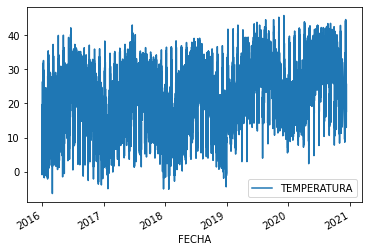

In [28]:
df_hmo.plot('FECHA', 'TEMPERATURA')

### Data preparation

In [29]:
#
# Set number of training and testing data
# 
train_set = dataset[0:train_days].reset_index(drop=True)
test_set = dataset[train_days: train_days+testing_days].reset_index(drop=True)
training_set = train_set.iloc[:, 1:2].values
testing_set = test_set.iloc[:, 1:2].values

In [30]:
#
# Normalize data first
#
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

In [31]:
#
# Split data into n_timestamp
#
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        if end_ix > len(sequence)-1:
            break
        # i to end_ix as input
        # end_ix as target output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test, y_test = data_split(testing_set_scaled, n_timestamp)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print ('X_train = ', X_train.shape)
print ('X_test = ', X_test.shape)

X_train =  (29990, 10, 1)
X_test =  (12553, 10, 1)


## Base Model: Bidirectional LSTM Model

In [32]:
if model_type == 1:
    # Single cell LSTM
    model = Sequential()
    model.add(LSTM(units = 50, dropout = 0.2, activation='relu',input_shape = (X_train.shape[1], 1)))
    model.add(Dense(units = 1))
if model_type == 2:
    # Stacked LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', dropout = 0.5, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               20800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [34]:
#
# Start training
#
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/10
938/938 [==============================] - 10s 8ms/step - loss: 0.0295
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 5.4567e-04
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 3.9081e-04
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 3.4812e-04
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 2.8277e-04
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 2.3698e-04
Epoch 7/10
938/938 [==============================] - 8s 8ms/step - loss: 2.0531e-04
Epoch 8/10
938/938 [==============================] - 8s 8ms/step - loss: 1.6227e-04
Epoch 9/10
938/938 [==============================] - 8s 8ms/step - loss: 1.3001e-04
Epoch 10/10
938/938 [==============================] - 8s 8ms/step - loss: 1.0252e-04


In [35]:
#
# Get predicted data
#
y_predicted = model.predict(X_test)

#
# 'De-normalize' the data
#
y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()

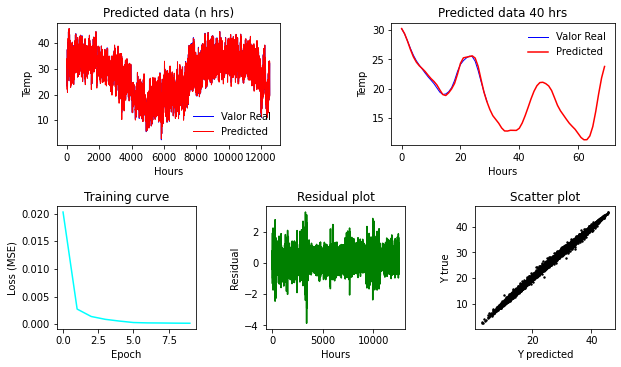

mse=0.2316
r2=0.9963


In [97]:
#
# Show results
#
plt.figure(figsize=(10,9))

plt.subplot(3, 1, 1)
plt.plot(dataset['TEMPERATURA'], color = 'black', linewidth=1, label = 'Valor Real')
plt.ylabel("Temp")
plt.xlabel("Hours")
plt.title("All data")


plt.subplot(3, 2, 1)
plt.plot(y_test_descaled, color = 'blue', linewidth=1, label = 'Valor Real')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temp")
plt.xlabel("Hours")
plt.title("Predicted data (n hrs)")

plt.subplot(3, 2, 2)
plt.plot(y_test_descaled[11980:12010], color = 'blue', linewidth=1, label = 'Valor Real')
plt.plot(y_predicted_descaled[11980:12050], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temp")
plt.xlabel("Hours")
plt.title("Predicted data 40 hrs")

plt.subplot(3, 3, 4)
plt.plot(epochs, loss, color='cyan')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 5)
plt.plot(y_test_descaled-y_predicted_descaled, color='green')
plt.ylabel("Residual")
plt.xlabel("Hours")
plt.title("Residual plot")

plt.subplot(3, 3, 6)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.5)
plt.show()



mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,4)))
print("r2=" + str(round(r2,4)))

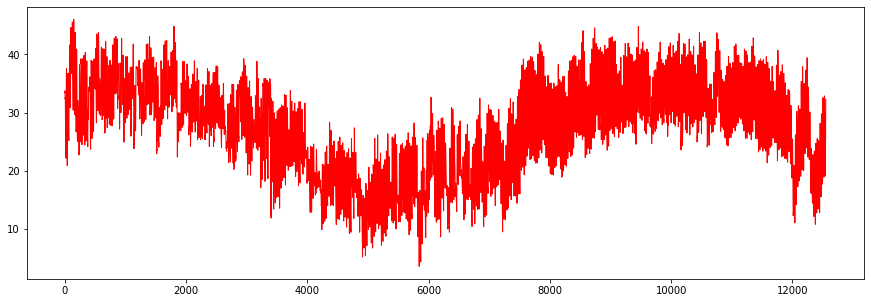

In [70]:
plt.figure(figsize=(15,5))
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted')

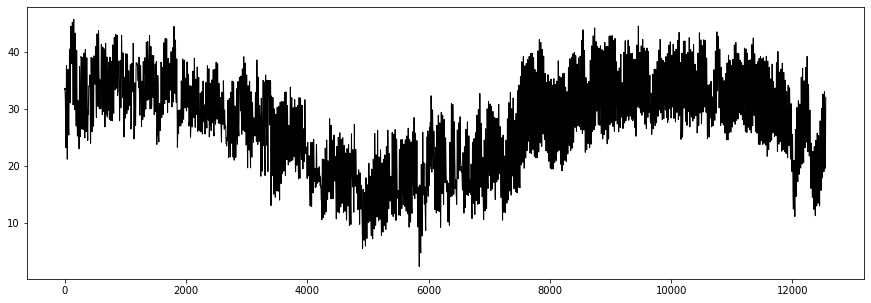

In [71]:
plt.figure(figsize=(15,5))
plt.plot(y_test_descaled, color = 'black',  linewidth=1, label = 'Predicted')

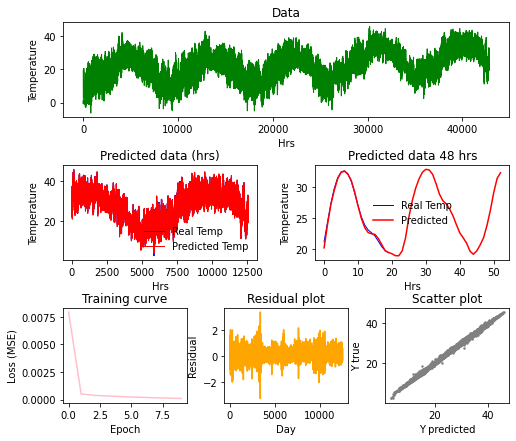

mse=0.13
r2=1.0


In [79]:
#
# Show results
#
plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['TEMPERATURA'], color = 'green', linewidth=1, label = 'True value')
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Data")


plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'blue', linewidth=1, label = 'Real Temp')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted Temp')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Predicted data (hrs)")

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[12500:12520], color = 'blue', linewidth=1, label = 'Real Temp')
plt.plot(y_predicted_descaled[12500:12568], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Predicted data 48 hrs")

plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='pink')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='orange')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='gray')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()



mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))

## Model Variation 1: Activation SIGMOID

In [87]:
model_01 = Sequential()
model_01.add(Bidirectional(LSTM(50, activation='sigmoid'), input_shape=(X_train.shape[1], 1)))
model_01.add(Dense(1))

In [88]:
model_01.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 100)               20800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [89]:
#
# Start training
#
model_01.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model_01.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/10
938/938 [==============================] - 10s 8ms/step - loss: 0.0512
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.0036
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.0016
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 0.0010
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 6.6918e-04
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 3.5169e-04
Epoch 7/10
938/938 [==============================] - 7s 8ms/step - loss: 2.6036e-04
Epoch 8/10
938/938 [==============================] - 7s 8ms/step - loss: 2.4313e-04
Epoch 9/10
938/938 [==============================] - 8s 8ms/step - loss: 2.1677e-04
Epoch 10/10
938/938 [==============================] - 8s 8ms/step - loss: 1.9253e-04


In [90]:
#
# Get predicted data
#
y_predicted = model_01.predict(X_test)

#
# 'De-normalize' the data
#
y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()

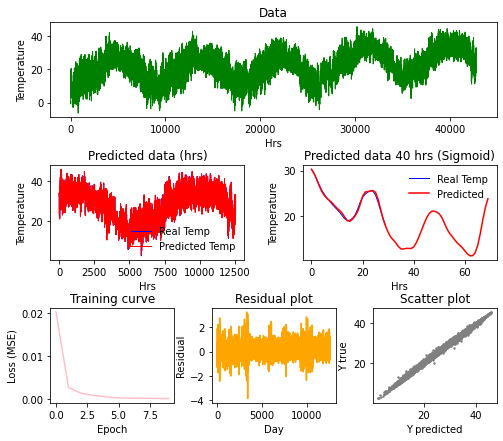

mse=0.23
r2=1.0


In [99]:
#
# Show results
#
plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['TEMPERATURA'], color = 'green', linewidth=1, label = 'True value')
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Data")


plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'blue', linewidth=1, label = 'Real Temp')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted Temp')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Predicted data (hrs)")

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[11980:12010], color = 'blue', linewidth=1, label = 'Real Temp')
plt.plot(y_predicted_descaled[11980:12050], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Predicted data 40 hrs (Sigmoid)")

plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='pink')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='orange')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='gray')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()



mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))

## Model Variation 2: Adamax Optimizer / Sigmoid Activation

In [100]:
model_02 = Sequential()
model_02.add(Bidirectional(LSTM(50, activation='sigmoid'), input_shape=(X_train.shape[1], 1)))
model_02.add(Dense(1))
model_02.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 100)               20800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [101]:
#
# Start training
#
model_02.compile(optimizer = 'adamax', loss = 'mean_squared_error')
history = model_02.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/10
938/938 [==============================] - 9s 8ms/step - loss: 0.0238
Epoch 2/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0052
Epoch 3/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0021
Epoch 4/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0015
Epoch 5/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0011
Epoch 6/10
938/938 [==============================] - 7s 8ms/step - loss: 7.7550e-04
Epoch 7/10
938/938 [==============================] - 7s 8ms/step - loss: 5.8102e-04
Epoch 8/10
938/938 [==============================] - 7s 8ms/step - loss: 4.4227e-04
Epoch 9/10
938/938 [==============================] - 7s 8ms/step - loss: 3.4288e-04
Epoch 10/10
938/938 [==============================] - 7s 8ms/step - loss: 2.8560e-04


In [102]:
#
# Get predicted data
#
y_predicted = model_02.predict(X_test)

#
# 'De-normalize' the data
#
y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()

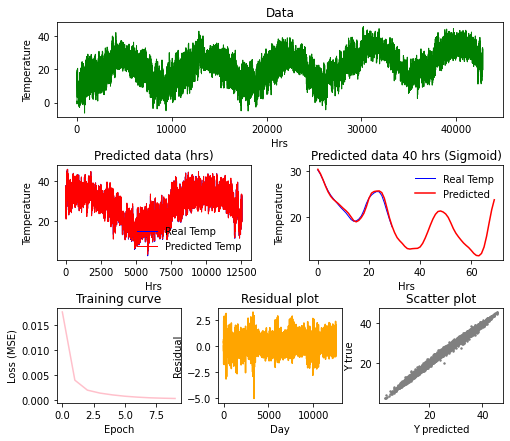

mse=0.41
r2=0.99


In [103]:
#
# Show results
#
plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['TEMPERATURA'], color = 'green', linewidth=1, label = 'True value')
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Data")


plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'blue', linewidth=1, label = 'Real Temp')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted Temp')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Predicted data (hrs)")

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[11980:12010], color = 'blue', linewidth=1, label = 'Real Temp')
plt.plot(y_predicted_descaled[11980:12050], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Predicted data 40 hrs (Sigmoid)")

plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='pink')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='orange')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='gray')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()



mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))

## Model Variation 3: Single Cell model

In [111]:
model_03 = Sequential()
model_03.add(LSTM(units = 50, dropout = 0.2, activation='relu',input_shape = (X_train.shape[1], 1)))
model_03.add(Dense(units = 1))
model_03.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [112]:
#
# Start training
#
model_03.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model_03.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/10
938/938 [==============================] - 6s 5ms/step - loss: 0.0374
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0036
Epoch 3/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0021
Epoch 4/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0013
Epoch 5/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0011
Epoch 6/10
938/938 [==============================] - 5s 6ms/step - loss: 0.0010
Epoch 7/10
938/938 [==============================] - 5s 5ms/step - loss: 8.3267e-04
Epoch 8/10
938/938 [==============================] - 5s 5ms/step - loss: 7.4558e-04
Epoch 9/10
938/938 [==============================] - 5s 6ms/step - loss: 7.8607e-04
Epoch 10/10
938/938 [==============================] - 5s 5ms/step - loss: 6.0522e-04


In [113]:
#
# Get predicted data
#
y_predicted = model_03.predict(X_test)

#
# 'De-normalize' the data
#
y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()

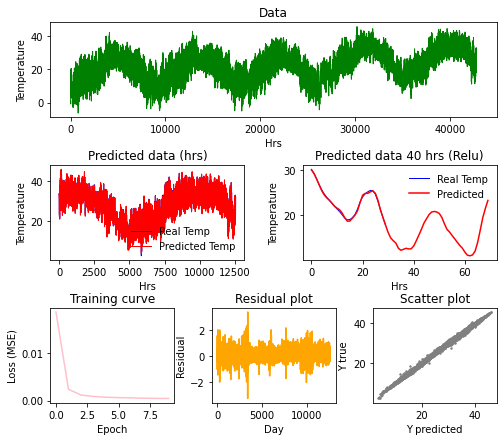

mse=0.13
r2=1.0


In [108]:
#
# Show results
#
plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['TEMPERATURA'], color = 'green', linewidth=1, label = 'True value')
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Data")


plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'blue', linewidth=1, label = 'Real Temp')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted Temp')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Predicted data (hrs)")

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[11980:12010], color = 'blue', linewidth=1, label = 'Real Temp')
plt.plot(y_predicted_descaled[11980:12050], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Predicted data 40 hrs (Relu)")

plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='pink')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='orange')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='gray')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()



mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))

## Model Variation 4: Single Cell Model 

Adam - Relu - Batch size = 64

In [114]:
model_04 = Sequential()
model_04.add(LSTM(units = 50, dropout = 0.2, activation='relu',input_shape = (X_train.shape[1], 1)))
model_04.add(Dense(units = 1))
model_04.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [115]:
#
# Start training
#
model_04.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model_04.fit(X_train, y_train, epochs = n_epochs, batch_size = 64)
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/10
469/469 [==============================] - 4s 6ms/step - loss: 0.0824
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0108
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0031
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0012
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 9.4718e-04
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 8.0898e-04
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 6.5905e-04
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 5.7531e-04
Epoch 9/10
469/469 [==============================] - 3s 6ms/step - loss: 5.2164e-04
Epoch 10/10
469/469 [==============================] - 3s 7ms/step - loss: 5.2307e-04


In [116]:
#
# Get predicted data
#
y_predicted = model_04.predict(X_test)

#
# 'De-normalize' the data
#
y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()

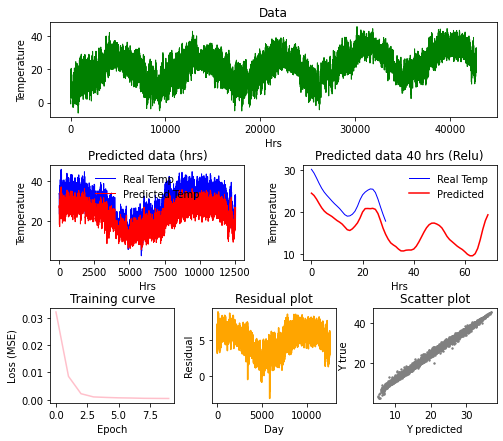

mse=27.83
r2=0.56


In [117]:
#
# Show results
#
plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['TEMPERATURA'], color = 'green', linewidth=1, label = 'True value')
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Data")


plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'blue', linewidth=1, label = 'Real Temp')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted Temp')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Predicted data (hrs)")

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[11980:12010], color = 'blue', linewidth=1, label = 'Real Temp')
plt.plot(y_predicted_descaled[11980:12050], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Predicted data 40 hrs (Relu)")

plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='pink')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='orange')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='gray')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()



mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))

## Model Variation 5: Stacked Model


Stacked Cell Model - Relu Activation - Adam Optimizer - Batch size = 32


In [119]:
model_05 = Sequential()
model_05.add(LSTM(50, activation='relu', dropout = 0.5, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_05.add(LSTM(50, activation='relu'))
model_05.add(Dense(1))
model_05.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 10, 50)            10400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [123]:
#
# Start training
#
model_05.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model_05.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/10
938/938 [==============================] - 12s 10ms/step - loss: 0.0024
Epoch 2/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0021
Epoch 3/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0021
Epoch 4/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0020
Epoch 5/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0019
Epoch 6/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0019
Epoch 7/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0020
Epoch 8/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0019
Epoch 9/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0018
Epoch 10/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0018


In [124]:
#
# Get predicted data
#
y_predicted = model_05.predict(X_test)

#
# 'De-normalize' the data
#
y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()

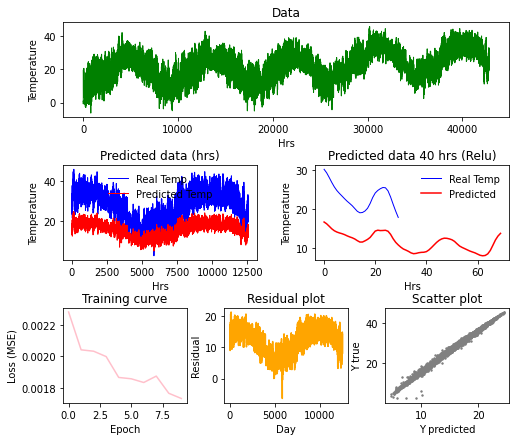

mse=157.88
r2=-1.51


In [125]:
#
# Show results
#
plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['TEMPERATURA'], color = 'green', linewidth=1, label = 'True value')
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Data")


plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'blue', linewidth=1, label = 'Real Temp')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted Temp')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Predicted data (hrs)")

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[11980:12010], color = 'blue', linewidth=1, label = 'Real Temp')
plt.plot(y_predicted_descaled[11980:12050], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hrs")
plt.title("Predicted data 40 hrs (Relu)")

plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='pink')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='orange')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='gray')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()



mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))